U-Net model works with convolution and spectrograms

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import librosa.display
from torch import Tensor
from typing import List, Tuple

In [8]:
def conv_block(in_ch: int, out_ch: int) -> nn.Sequential:
    """
    Create a convolutional block with two Conv2D layers and ReLU activations.

    Parameters:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels for each Conv2D layer.

    Returns:
        nn.Sequential: A sequential block containing two Conv2D layers
                       with ReLU activations.
    """
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )


In [9]:
class UNet(nn.Module):
    def __init__(self, input_channels: int = 1, output_channels: int = 9) -> None:
        """
        Initialize the U-Net model architecture.

        Parameters:
            input_channels (int): Number of input channels in the image/spectrogram.
            output_channels (int): Number of output channels (e.g., classes or instruments).
        """
        super(UNet, self).__init__()

        # Encoder blocks
        self.encoder1 = conv_block(input_channels, 16)
        self.encoder2 = conv_block(16, 64)
        self.encoder3 = conv_block(64, 128)

        # Bottleneck (middle block)
        self.middle = conv_block(128, 128)

        # Decoder blocks
        self.decoder3 = conv_block(128 + 128, 128)
        self.decoder2 = conv_block(128 + 64, 64)
        self.decoder1 = conv_block(64 + 16, 16)

        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(16, output_channels, kernel_size=1),
            nn.Sigmoid()  # Ensures outputs are in the range [0, 1]
        )

        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: Tensor) -> Tensor:
        """
        Run a forward pass of the U-Net model on input `x`.

        Parameters:
            x (Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            out (Tensor): Output tensor of shape (batch_size, output_channels, height, width),
                          with values between 0 and 1 due to sigmoid activation.
        """
        # Encoder pathway
        e1 = self.encoder1(x)
        p1 = self.pool(e1)

        e2 = self.encoder2(p1)
        p2 = self.pool(e2)

        e3 = self.encoder3(p2)
        p3 = self.pool(e3)

        # Middle (bottleneck) layer
        mid = self.middle(p3)

        # Decoder pathway
        d3 = F.interpolate(mid, size=e3.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3(d3)

        d2 = F.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2(d2)

        d1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1(d1)

        # Final output
        out = self.final(d1)
        return out


Spectrogram Dataset Class

In [ ]:
class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths: List[str]) -> None:
        """
        Initialize the dataset with the file paths of the mix and stems.
        Assumes the first file is the mix, followed by the stems.

        Parameters:
            file_paths (List[str]): List of file paths. The first is the mix,
                                    the remaining are stems for source separation.
        """
        self.mix_path = file_paths[0]         # First file is the mix
        self.stem_paths = file_paths[1:]      # Remaining files are the stems

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Always returns 1, since dataset is initialized per mix.
        """
        return 1

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """
        Loads the mix and stem waveforms, converts them to normalized
        spectrograms, and returns them as tensors.

        Parameters:
            idx (int): Index of the sample (unused, always returns index 0).

        Returns:
            mixed_tensor (Tensor): Normalized magnitude spectrogram of the mix,
                                   shape (1, freq_bins, time_frames).
            stems_tensor (Tensor): Stack of normalized spectrograms of each stem,
                                   shape (num_stems, freq_bins, time_frames).
        """
        # Load mix waveform and compute magnitude spectrogram
        y_mix, sr = librosa.load(self.mix_path, sr=44100)
        S_mix = librosa.stft(y_mix[:2000000])
        S_mix_amp = np.abs(S_mix)
        ref_value = np.max(S_mix_amp)

        S_mix_dB = librosa.amplitude_to_db(S_mix_amp, ref=ref_value)
        S_mix_dB = np.clip(S_mix_dB, -80, 0)
        S_mix_dB_norm = (S_mix_dB + 80) / 80  # Normalize to [0, 1]

        mix_time_len = S_mix_dB_norm.shape[1]

        # Compute spectrograms for each stem
        stems_spectrograms = []
        for stem_path in self.stem_paths:
            y_stem, _ = librosa.load(stem_path, sr=44100)

            # Optional debug output
            #sf.write("test_output.wav", y_stem, sr)

            S_stem = librosa.stft(y_stem[:2000000])
            S_stem_amp = np.abs(S_stem)
            S_stem_dB = librosa.amplitude_to_db(S_stem_amp, ref=ref_value)
            S_stem_dB = np.clip(S_stem_dB, -80, 0)
            S_stem_dB_norm = (S_stem_dB + 80) / 80

            # Align stem with mix duration
            stem_time_len = S_stem_dB_norm.shape[1]
            if stem_time_len > mix_time_len:
                S_stem_dB_norm = S_stem_dB_norm[:, :mix_time_len]
            elif stem_time_len < mix_time_len:
                padding = mix_time_len - stem_time_len
                S_stem_dB_norm = np.pad(
                    S_stem_dB_norm,
                    pad_width=((0, 0), (0, padding)),
                    mode='constant'
                )

            stems_spectrograms.append(S_stem_dB_norm)

        # Convert to torch tensors
        mixed_tensor = torch.tensor(S_mix_dB_norm, dtype=torch.float32).unsqueeze(0)
        stems_tensor = torch.tensor(np.array(stems_spectrograms), dtype=torch.float32)

        return mixed_tensor, stems_tensor


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Train Model

Model initialized. Beginning training...


Epoch 1/2: 100%|██████████| 1/1 [00:32<00:00, 32.10s/batch, loss=2.1699]


Epoch 1, Loss: 2.1699


Epoch 2/2: 100%|██████████| 1/1 [00:29<00:00, 29.66s/batch, loss=2.1678]

Epoch 2, Loss: 2.1678


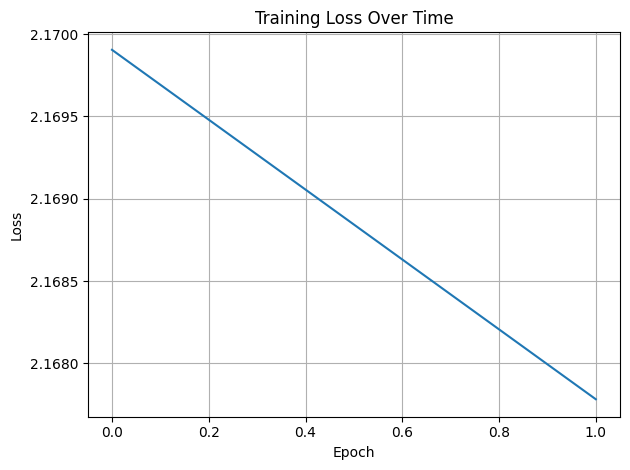

In [15]:
# Clear GPU memory before training
torch.cuda.empty_cache()

# === Config ===
num_epochs = 2
batch_size = 5

# Resolve project root and data paths
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
track_name = "Track00001"
mix_path = [os.path.join(project_root, "data", "raw", track_name, "mix.wav")]

stems_paths = [
    os.path.join(project_root, "data", "raw", track_name, "stems", f"S{str(i).zfill(2)}.wav")
    for i in [0, 1, 2, 3, 4, 5, 7, 8, 9, 10]
]

# === Dataset & DataLoader ===
dataset = SpectrogramDataset(mix_path + stems_paths)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# === Model Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_stems = len(stems_paths)  # Dynamically infer number of output channels
model = UNet(input_channels=1, output_channels=num_stems).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === Training ===
print("Model initialized. Beginning training...")
losses: List[float] = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

    for mixed, stems in progress_bar:
        # Normalize input and targets to [-1, 1]
        transform = transforms.Normalize(mean=[0.5], std=[0.5])
        mixed = transform(mixed).to(device)
        stems = transform(stems).to(device)

        optimizer.zero_grad()
        outputs = model(mixed)

        # Align model output length with stem spectrograms
        outputs = outputs[..., :stems.shape[-1]]

        loss = criterion(outputs, stems)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        torch.cuda.empty_cache()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

# === Plot Training Loss ===
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot output spectrograms

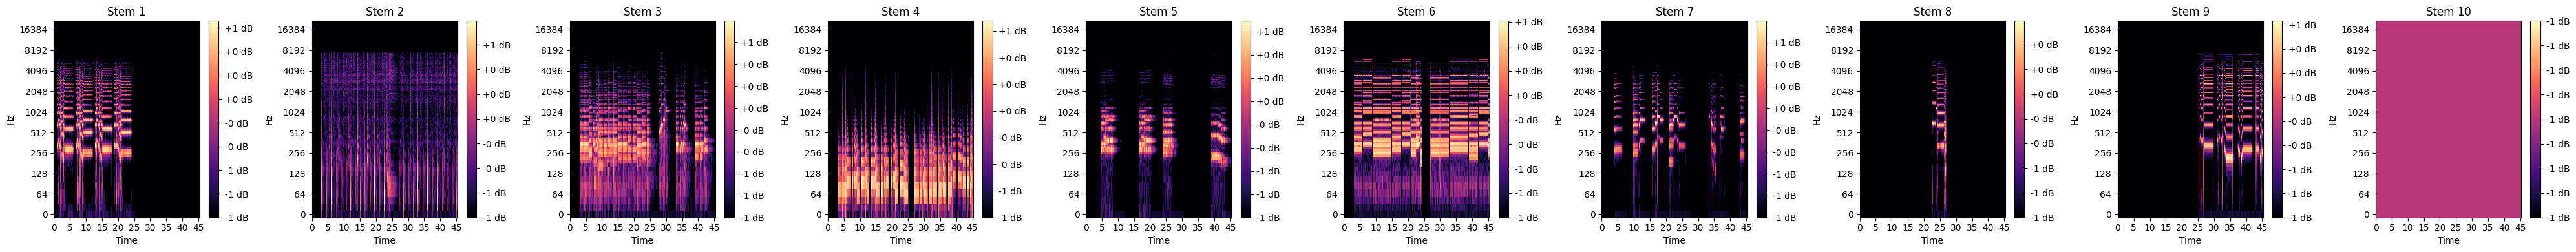

In [17]:
# Extract first item from batch: (num_stems, freq, time)
stem_spectrogram = stems[0].detach().cpu().numpy()

# === Parameters ===
sr = 44100
hop_length = 512
num_stems = stem_spectrogram.shape[0]

# === Plot spectrograms ===
fig, axes = plt.subplots(
    nrows=1,
    ncols=num_stems,
    figsize=(4 * num_stems, 4),
    squeeze=False
)

for i in range(num_stems):
    ax = axes[0, i]

    # Display spectrogram
    img = librosa.display.specshow(
        stem_spectrogram[i],  # shape: (freq, time)
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='log',
        cmap='magma',
        ax=ax
    )

    ax.set_title(f"Stem {i + 1}")
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

plt.tight_layout()
plt.show()